In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install 

In [2]:
def lms(y, x, Ntaps, μ):
    """
    Apply the LMS (Least Mean Squares) algorithm for equalization.

    Parameters:
        y (ndarray): The received signal.
        x (ndarray): The reference signal.
        Ntaps (int): The number of filter taps.
        μ (float): The LMS step size.

    Returns:
        tuple: A tuple containing:
            - ndarray: The equalized signal.
            - ndarray: The final equalizer filter coefficients.
            - ndarray: The squared error at each iteration.

    """
    # Initialize the equalizer filter coefficients
    h = np.zeros(Ntaps)
    L = len(h)//2 #decision delay
    
    # Apply the LMS algorithm    
    squaredError = np.zeros(y.shape)
    out  = np.zeros(y.shape)
    ind = np.arange(-L,L+1)
    
    y = np.pad(y,(L,L))
    
    # Iterate through each sample of the signal
    for i in range(L, len(y)-L):
        y_vec = y[i+ind][-1::-1]
        
        # Generate the estimated signal using the equalizer filter
        xhat = np.dot(y_vec, h)

        # Compute the error between the estimated signal and the reference signal
        error = x[i-L] - xhat
          
        # Update the filter coefficients using the LMS update rule
        h += μ * y_vec * error  
        
        squaredError[i-L] = error**2
        out[i-L] = xhat
        
    return out, h, squaredError

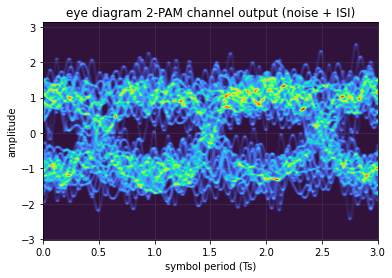

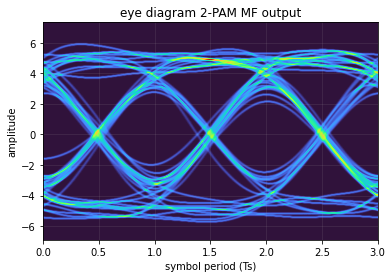

BER (sem equalização) = 0.00e+00
BER (com equalização) = 0.00e+00


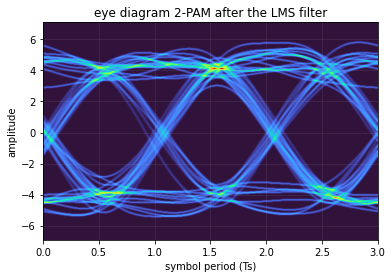

In [13]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numpy.random import normal
from commpy.utilities import upsample

from optic.modulation import modulateGray, demodulateGray, GrayMapping
from optic.dsp import firFilter, pulseShape, pnorm, decimate
from optic.metrics import signal_power
from optic.plot import eyediagram, pconst
from optic.models import awgn

# Simulação de transmissão em canal AWGN
SNRdB = 20  # relação sinal-ruído
M      = 2  # ordem do formato de modulação
constType = 'pam' # 'qam', 'psk', 'pam' or 'ook'

# parâmetros do equalizador
Ntaps = 15
μ = 0.001

# parâmetros da simulação
SpS = 16            # Amostras por símbolo
Rs  = 100e6         # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

# Define constelação    
constSymb = GrayMapping(M, constType)
Es = np.mean(np.abs(constSymb**2))

constSymb = pnorm(constSymb) 

# gera sequência de bits pseudo-aleatória 
bitsTx = np.random.randint(2, size = int(100000*np.log2(M)))

# gera sequência de símbolos da modulação
symbTx = modulateGray(bitsTx, M, constType)    
symbTx = pnorm(symbTx) # normaliza energia média dos símbolos

# upsampling
symbolsUp = upsample(symbTx, SpS)

# formatação de pulso NRZ 
pulse = pulseShape('nrz', SpS)
sigTx = firFilter(pulse, symbolsUp)
sigTx = pnorm(sigTx)

# ruído gaussiano branco
Nsamples = sigTx.size
σ2 = 1/(10**(SNRdB/10))
σ  = np.sqrt(σ2*SpS)

if constType == 'pam':
    ruido  = normal(0, σ, Nsamples) # real-valued AWGN
elif constType == 'qam':
    ruido  = 1/np.sqrt(2)*(normal(0, σ, Nsamples) + 1j*normal(0, σ, Nsamples)) # complex-valued AWGN

# diagrama de olho
eyediagram(sigTx+ruido, Nsamples, SpS, plotlabel= str(M)+'-'+constType.upper()+' channel output (noise + ISI)', ptype='fancy')
eyediagram(firFilter(pulse, sigTx+ruido), Nsamples, SpS, plotlabel= str(M)+'-'+constType.upper()+' MF output', ptype='fancy')

# filtro casado
sigRx = firFilter(pulse, sigTx+ruido)
sigRx = pnorm(sigRx)

# downsampling
y = sigRx[0::SpS].real
y = pnorm(y)

# detector ML
bitsRx = demodulateGray(np.sqrt(Es)*y, M, constType)

# Calcula BER sem equalização
discard = int(0.25*len(bitsTx))
BERpre = np.mean(bitsRx[discard:]^bitsTx[discard:])

# equalizador LMS 
symbRx, h_eq, squaredError = lms(y, symbTx, Ntaps, μ)
symbRx = pnorm(symbRx)

# detector ML
bitsRx = demodulateGray(np.sqrt(Es)*symbRx, M, constType)

# Calcula BER após equalização
discard = int(0.25*len(bitsTx))
BERpos = np.mean(bitsRx[discard:]^bitsTx[discard:])

print(f'BER (sem equalização) = {BERpre:.2e}')
print(f'BER (com equalização) = {BERpos:.2e}')

# aplicando o filtro obtido pelo equalizador LMS no sinal obtido na saída do filtro casado
sigLMS = firFilter(upsample(h_eq, SpS), firFilter(pulse, sigTx+ruido)) 

# observando o diagrama de olho como se o filtro obtido pelo equalizador LMS fosse aplicado na saída do filtro casado
eyediagram(sigLMS, Nsamples, SpS, plotlabel= str(M)+'-'+constType.upper()+' after the LMS filter', ptype='fancy')

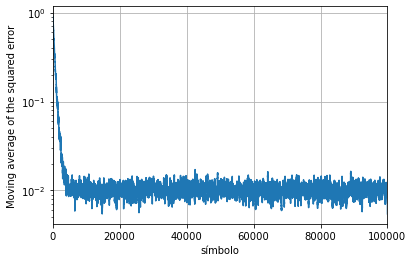

In [14]:
L = 100
MA_SE = np.convolve(np.ones(L)/L, squaredError, 'same')

plt.semilogy(MA_SE);
plt.xlabel('símbolo')
plt.ylabel('Moving average of the squared error')
plt.grid()
plt.xlim(0, len(squaredError));

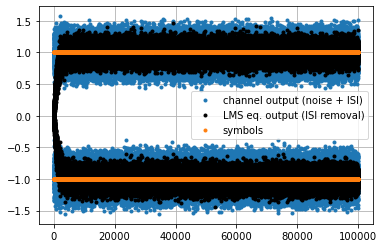

In [15]:
plt.plot(y,'.', label='channel output (noise + ISI)')
plt.plot(symbRx,'k.', label='LMS eq. output (ISI removal)')
plt.plot(symbTx,'.', label='symbols')
plt.legend()
plt.grid()

(-0.21860941920048077, 1.233896695978642)

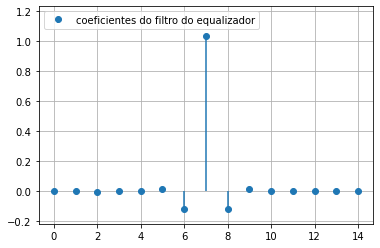

In [26]:
plt.stem(np.arange(Ntaps), h_eq, basefmt=" ", label='coeficientes do filtro do equalizador');
plt.grid()
plt.legend(loc='upper left')
plt.ylim(min(h_eq)-0.1,max(h_eq)+0.2)

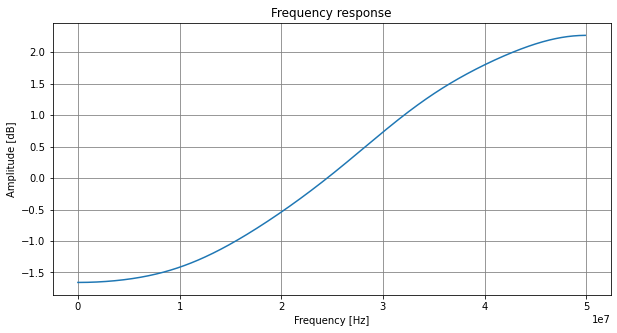

In [17]:
fs = Rs
ω, h = sp.signal.freqz(b=h_eq, a=1)
x = ω * fs * 1.0 / (2 * np.pi)
y = 20*np.log10(np.abs(h))

plt.figure(figsize=(10,5))
plt.plot(x, y)
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency [Hz]')
plt.title('Frequency response')
plt.grid(which='both', linestyle='-', color='grey')